In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib notebook
%pylab
import pickle #per salvare la lista h come una variabile

import anndata

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [97]:
import h5py

In [98]:
h5py.__version__

'2.10.0'

In [2]:
df = pd.read_table("../sc_mixology/data/csv/sc_dropseq.count.csv.gz", compression="gzip", sep=",")

In [3]:
df.head()

,CELL_000001,CELL_000002,CELL_000003,CELL_000004,CELL_000005,CELL_000006,CELL_000007,CELL_000008,CELL_000009,CELL_000010,...,CELL_000228,CELL_000229,CELL_000230,CELL_000231,CELL_000233,CELL_000237,CELL_000238,CELL_000246,CELL_000249,CELL_000302
ENSG00000223849,0,0,0,0,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000225355,0,0,1,2,5,3,4,0,3,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000135093,0,0,0,0,3,2,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
ENSG00000183579,0,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000138363,4,14,22,13,7,5,10,6,7,10,...,0,0,0,1,3,0,2,3,0,0


In [4]:
df.shape

(15127, 225)

##### Qui in pratica cambio tutti i nomi del ciclo cellulare in ensg ID in più divido quelli della fase s e g2 perchè siccome alcuni possono essere tolti successivamente, non so la posizione nel momento in cui sono analizzati

In [5]:
nomi=pd.read_csv('../sc_mixology/nomi_geni.txt.gz', compression= 'gzip')
cell_cycle_genes = [x.strip() for x in open('../sc_mixology/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


##### qui faccio il cambio di nome

In [6]:
ensg_s_genes =[nomi.loc[idx, "Gene stable ID"] for idx in nomi.index if nomi.loc[idx, "Gene name"] in s_genes]
ensg_g2m_genes =[nomi.loc[idx, "Gene stable ID"] for idx in nomi.index if nomi.loc[idx, "Gene name"] in g2m_genes]

##### lo stesso vale per i geni mitocondriali

In [7]:
adata = anndata.AnnData(df.T)#.values.T, obs=df.columns, var=df.index)
mito_genes = [nomi.loc[idx, "Gene stable ID"] for idx in nomi.index if nomi.loc[idx, "Gene name"].startswith("MT-") and 
             nomi.loc[idx, "Gene stable ID"] in adata.var_names]

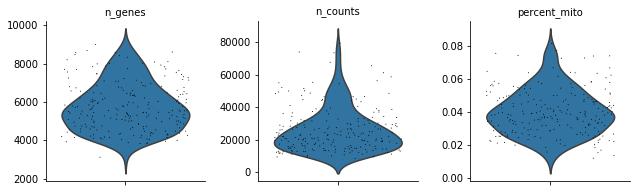

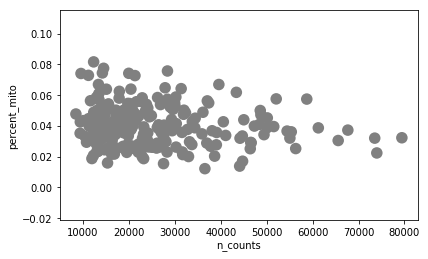

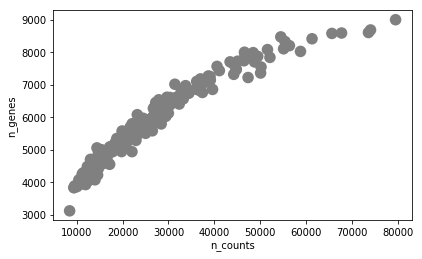

In [8]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=3)

 
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)


np.sum(adata[:, mito_genes].X, axis=1)

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)


sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')



adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [9]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


In [10]:
sc.tl.score_genes_cell_cycle(adata, s_genes=ensg_s_genes, g2m_genes=ensg_g2m_genes)


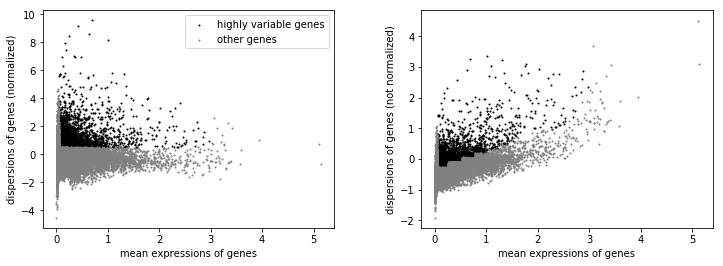

In [11]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [12]:
adata = adata[:, adata.var['highly_variable']]


In [13]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score','n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10) #i geni con una varianza più alta di 10 gli viene attribuita varianza uguale a 10

Trying to set attribute `.obs` of view, making a copy.
... storing 'phase' as categorical


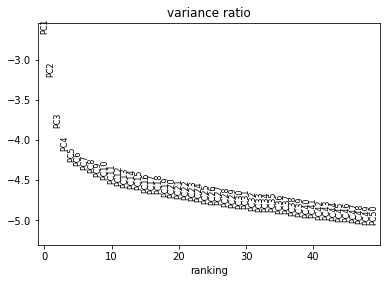

In [14]:
sc.tl.pca(adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)




In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [16]:
sc.tl.umap(adata) 

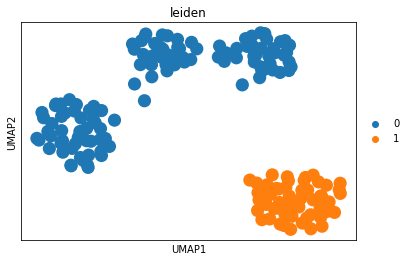

In [17]:
sc.tl.leiden(adata, resolution=0.05)
sc.pl.umap(adata, color="leiden")

In [18]:
adata.write('adata_dropseq/adata_sc_dropseq.h5ad')

In [18]:

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

##### ho creato un database che tiene conto dei geni che hanno una differenza di espressione significativa

In [19]:
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

In [21]:
for x in nomi.loc[df_significativo.loc[:,'2'].values, "Gene name"]:
    print(x)

SyntaxError: unexpected EOF while parsing (<ipython-input-21-9696c5efde17>, line 2)

In [ ]:
pwd

##### ora voglio dare i nomi ai miei gruppi separati di cellule e lo faccio attraverso il metadata con le cell annotation

In [20]:
cell_annotation= pd.read_table('../sc_mixology/data/csv/sc_dropseq.metadata.csv.gz', compression="gzip", sep=",", index_col=0)

In [21]:
cell_annotation.head()

,unaligned,aligned_unmapped,mapped_to_exon,mapped_to_intron,ambiguous_mapping,mapped_to_ERCC,mapped_to_MT,number_of_genes,total_count_per_cell,non_mt_percent,non_ribo_percent,outliers,cell_line,cell_line_demuxlet,demuxlet_cls
CELL_000001,101619,5913,254630,64711,6942,0,7566,9284,74261,0.848023,0.895463,False,H1975,H1975,SNG
CELL_000002,95759,10881,234950,86606,5960,0,7864,9255,68421,0.857982,0.899124,False,HCC827,HCC827,SNG
CELL_000003,92448,6336,251846,29568,6869,0,7975,9650,80134,0.839781,0.893578,False,HCC827,HCC827,SNG
CELL_000004,92454,6197,235800,27495,6058,0,4888,9257,74611,0.852180,0.883435,False,HCC827,HCC827,SNG
CELL_000005,74750,6194,218966,29425,5872,0,6211,9125,66161,0.839105,0.898157,False,H1975,H1975,SNG


In [22]:
cell_annotation.columns

Index(['unaligned', 'aligned_unmapped', 'mapped_to_exon', 'mapped_to_intron',
       'ambiguous_mapping', 'mapped_to_ERCC', 'mapped_to_MT',
       'number_of_genes', 'total_count_per_cell', 'non_mt_percent',
       'non_ribo_percent', 'outliers', 'cell_line', 'cell_line_demuxlet',
       'demuxlet_cls'],
      dtype='object')

##### qui conosco le cell anotation per ogni celula e do quindi ad ogni cellula la sua annotaizone

In [23]:
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

In [24]:
adata.obs.loc[:, "cell_line_demuxlet"] = cell_annotation.loc[adata.obs_names, "cell_line_demuxlet"]
adata.obs.columns

Index(['n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'leiden', 'cell_line', 'cell_line_demuxlet'],
      dtype='object')

... storing 'cell_line' as categorical
... storing 'cell_line_demuxlet' as categorical


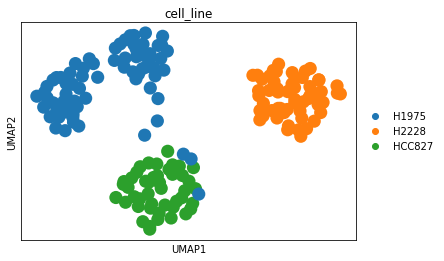

In [27]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line")

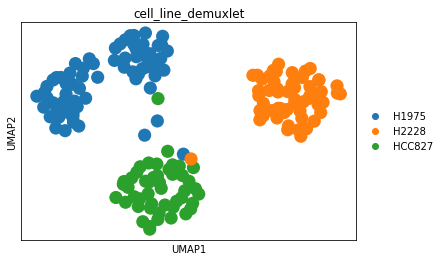

In [28]:
%matplotlib inline
sc.pl.umap(adata, color="cell_line_demuxlet")

## grafi

In [ ]:
import graph_tool.all as gt

In [ ]:
g = gt.Graph(directed=False)

In [ ]:
adata.uns['neighbors']

In [ ]:
adj=adata.uns['neighbors']['connectivities'] #binario o si o no
w_adj=adata.uns['neighbors']['distances'] #pesato, mi da un valore in scala

In [ ]:
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [ ]:
w_adj = w_adj /w_adj.max()
w_adj = 1 - w_adj.todense()

In [ ]:
wg = gt.Graph(directed=False)
edge_weights = wg.new_edge_property('double')
wg.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(w_adj,1))
nedges = len(nnz[0])
wg.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

##### nested SBM

In [50]:
n_state = gt.minimize_nested_blockmodel_dl(g)

In [51]:
levels = n_state.get_levels()
for s in levels:
    print(s)

<BlockState object with 6 blocks (6 nonempty), degree-corrected, for graph <Graph object, undirected, with 173 vertices and 1284 edges at 0x7f345fdfd150>, at 0x7f345fca1210>
<BlockState object with 3 blocks (3 nonempty), for graph <Graph object, undirected, with 6 vertices and 17 edges at 0x7f3444961390>, at 0x7f3447c25a90>
<BlockState object with 1 blocks (1 nonempty), for graph <Graph object, undirected, with 3 vertices and 6 edges at 0x7f34449922d0>, at 0x7f3447c1dc90>


In [52]:
state_ndc = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state_dc  = gt.minimize_nested_blockmodel_dl(g, deg_corr=True)

print("Non-degree-corrected DL:\t", state_ndc.entropy())
print("Degree-corrected DL:\t", state_dc.entropy())

Non-degree-corrected DL:	 3130.794035086801
Degree-corrected DL:	 3156.0354571473417


In [53]:
print(u"ln \u039b: ", state_dc.entropy() - state_ndc.entropy()) # sembra essere migliore la ndc

ln Λ:  25.24142206054057


## paga

In [39]:
sc.tl.leiden(adata, resolution=1.0)

In [40]:
sc.tl.paga(adata, groups='leiden')

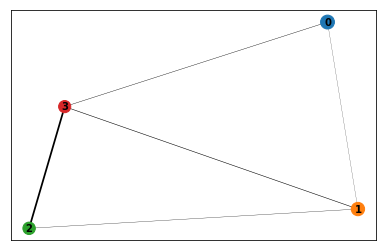

In [41]:
sc.pl.paga(adata, color=['leiden'])

In [42]:
adata.obs['cell_line'].cat.categories

Index(['H1975', 'H2228', 'HCC827'], dtype='object')

In [43]:
sc.tl.paga(adata, groups='cell_line')

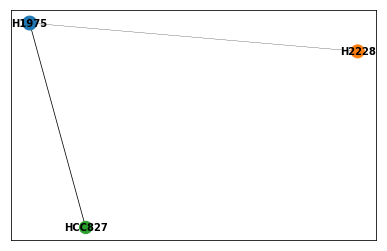

In [44]:
sc.pl.paga(adata, threshold=0.03)

In [45]:
sc.tl.paga(adata, groups='cell_line_demuxlet')

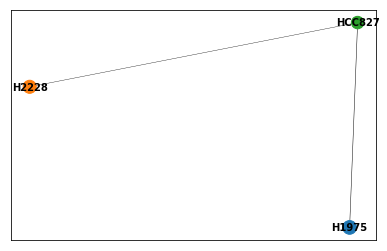

In [46]:
sc.pl.paga(adata, threshold=0.03)

In [47]:
sc.tl.draw_graph(adata, init_pos='paga')

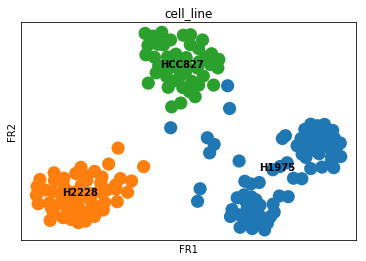

In [48]:
sc.pl.draw_graph(adata, color=['cell_line'], legend_loc='on data')

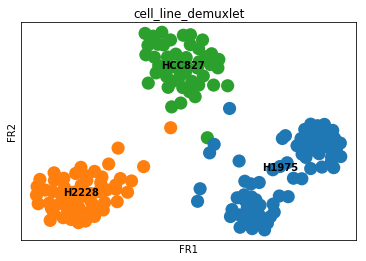

In [49]:
sc.pl.draw_graph(adata, color=['cell_line_demuxlet'], legend_loc='on data')

# paragone sbm vs leiden
### Leiden

In [25]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [26]:
sc.tl.umap(adata) 

... storing 'cell_line' as categorical
... storing 'cell_line_demuxlet' as categorical


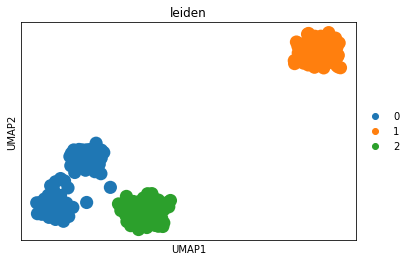

In [27]:
sc.tl.leiden(adata, resolution=0.056)
sc.pl.umap(adata, color="leiden") 

In [28]:
resolutions = np.arange(0, 1, 0.005)
leiden_clusters = pd.DataFrame(index=adata.obs_names, columns=resolutions)

In [29]:
for r in resolutions:
    sc.tl.leiden(adata, resolution=r)
    leiden_clusters.loc[:, r] = adata.obs.leiden

In [30]:
leiden_clusters.to_csv('adata_dropseq/dropseq_leiden_clusters.csv')

### SBM

In [31]:
import graph_tool.all as gt
g = gt.Graph(directed=False)

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


In [32]:
adj=adata.uns['neighbors']['connectivities']
w_adj=adata.uns['neighbors']['distances']

In [33]:
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [34]:
w_adj = w_adj /w_adj.max()
w_adj = 1 - w_adj.todense()

In [35]:
wg = gt.Graph(directed=False)
edge_weights = wg.new_edge_property('double')
wg.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(w_adj,1))
nedges = len(nnz[0])
wg.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [48]:
n_state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False)

In [102]:
pickle.dump(n_state, open("adata_dropseq/dropseq_nested_state.pkl", "wb"), 2)

In [49]:
n_state

<NestedBlockState object, with base <BlockState object with 10 blocks (10 nonempty), for graph <Graph object, undirected, with 173 vertices and 1286 edges at 0x7f32d593acd0>, at 0x7f32d32cc490>, and 4 levels of sizes [(173, 10), (10, 4), (4, 2), (2, 1)] at 0x7f32d54fed50>

In [50]:
n_state.print_summary()

l: 0, N: 173, B: 10
l: 1, N: 10, B: 4
l: 2, N: 4, B: 2
l: 3, N: 2, B: 1


In [51]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(n_state.project_level(1).get_blocks()))

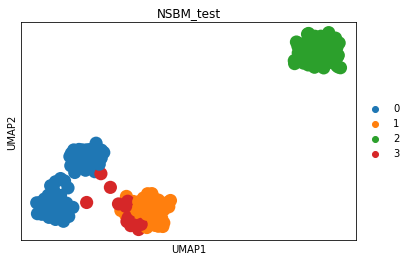

In [52]:
sc.pl.umap(adata, color="NSBM_test")

In [53]:
NSBM_clusters=pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)
print(NSBM_clusters)

cell_line  H1975  H2228  HCC827
NSBM_test                      
0             66      0       0
1              0      0      39
2              0     56       0
3              6      0       6


In [58]:
NSBM_clusters.to_csv('adata_dropseq/dropseq_nsbm_clusters.csv')

### mi leiden vs nsbm

In [54]:
import sklearn.metrics

In [55]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, adata.obs.cell_line)

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8207261095899554

In [56]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, leiden_clusters.loc[:,0.05])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.4986475122818438

In [57]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, leiden_clusters.loc[:,0.05])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.5805854178138226

In [58]:
MI_= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, leiden_clusters.loc[:,x]) for x in resolutions]
RS= [sklearn.metrics.adjusted_rand_score( adata.obs.NSBM_test, leiden_clusters.loc[:,x]) for x in resolutions]
MI_cl= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, leiden_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

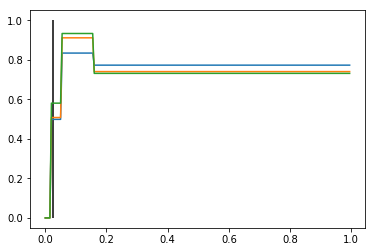

In [59]:
plot(resolutions, MI_)
plot(resolutions, RS)
plot(resolutions, MI_cl)
vlines(0.025, 0, 1)

In [60]:
NSBM = np.array([list(n_state.project_level(x).get_blocks()) for x in range(3)])
NSBM

array([[0, 1, 1, 1, 2, 0, 3, 2, 0, 2, 3, 0, 1, 1, 1, 3, 4, 5, 3, 2, 6, 0,
        4, 1, 7, 0, 2, 3, 1, 7, 3, 3, 8, 9, 5, 3, 4, 2, 1, 1, 3, 3, 1, 4,
        2, 9, 2, 5, 0, 4, 7, 0, 1, 3, 6, 3, 7, 4, 7, 7, 0, 1, 8, 5, 8, 8,
        6, 6, 3, 8, 5, 5, 6, 5, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 2, 5, 4, 9,
        2, 4, 6, 4, 6, 4, 4, 4, 3, 5, 4, 4, 8, 8, 9, 5, 3, 6, 4, 7, 0, 5,
        6, 7, 6, 4, 9, 7, 5, 4, 4, 6, 7, 4, 6, 4, 5, 8, 4, 7, 4, 6, 4, 5,
        5, 4, 4, 4, 4, 4, 5, 4, 9, 6, 5, 5, 6, 4, 4, 6, 6, 4, 8, 8, 7, 5,
        4, 5, 7, 7, 4, 4, 8, 7, 7, 8, 6, 6, 6, 7, 6, 7, 4, 7, 5],
       [0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 2, 2, 1, 2, 0, 0, 0,
        2, 1, 0, 0, 0, 2, 1, 0, 2, 2, 3, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2,
        0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 0, 1, 3, 1, 3, 3,
        0, 0, 2, 3, 1, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 2, 0,
        0, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 3, 3, 0, 1, 2, 0, 2, 0, 0, 1,
        0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 0,

In [61]:
MI_nsbm = [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, NSBM[x]) for x in range(3)]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


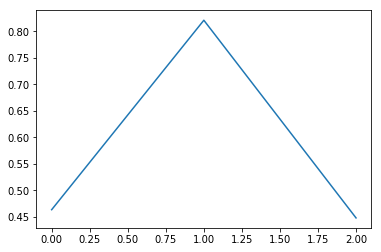

In [62]:
plot(range(3), MI_nsbm)

### df leiden vs nsbm

In [63]:
SBM_gruppi=pd.Categorical(adata.obs.NSBM_test).unique()
SBM_gruppi

[0, 1, 2, 3]
Categories (4, int64): [0, 1, 2, 3]

In [64]:
leiden_vs_SBM=pd.DataFrame(index=resolutions, columns=SBM_gruppi)

In [65]:
MI_leiden_NSBM0= [sklearn.metrics.adjusted_mutual_info_score( NSBM[0], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM1= [sklearn.metrics.adjusted_mutual_info_score( NSBM[1], leiden_clusters.loc[:,x]) for x in resolutions]
MI_leiden_NSBM2= [sklearn.metrics.adjusted_mutual_info_score( NSBM[2], leiden_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

In [66]:
leiden_vs_SBM.loc[:,0]=MI_leiden_NSBM0
leiden_vs_SBM.loc[:,1]=MI_leiden_NSBM1
leiden_vs_SBM.loc[:,2]=MI_leiden_NSBM2

In [67]:
leiden_vs_SBM.head()

,0,1,2,3
0.000,2.17356e-16,-5.49008e-17,1.83087e-16,NaN
0.005,2.17356e-16,-5.49008e-17,1.83087e-16,NaN
0.010,2.17356e-16,-5.49008e-17,1.83087e-16,NaN
0.015,2.17356e-16,-5.49008e-17,1.83087e-16,NaN
0.020,0.281965,0.498648,0.223808,NaN


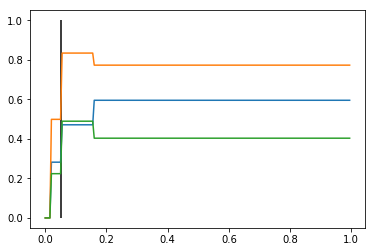

In [68]:
plot(leiden_vs_SBM)
vlines(0.05, 0, 1)

In [69]:
leiden_vs_SBM.to_csv('adata_dropseq/dropseq_mi_leiden_nsbm.csv')

# paragone louvain vs nsbm

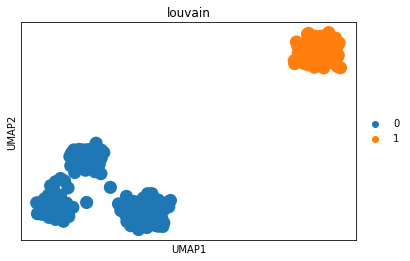

In [70]:
sc.tl.louvain(adata, resolution=0.057)
sc.pl.umap(adata, color="louvain") 

In [71]:
resolutions= np.arange(0, 1, 0.005)
louvain_clusters= pd.DataFrame(index=adata.obs_names, columns=resolutions)

In [72]:
for r in resolutions:
    sc.tl.louvain(adata, resolution=r)
    louvain_clusters.loc[:, r] = adata.obs.louvain

In [79]:
louvain_clusters.to_csv('adata_dropseq/dropseq_louvain_clusters.csv')

In [73]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, louvain_clusters.loc[:,0.06])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.833913716529988

In [74]:
sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, louvain_clusters.loc[:,0.06])

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.9329869027376525

In [75]:
MI_= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.NSBM_test, louvain_clusters.loc[:,x]) for x in resolutions]
RS= [sklearn.metrics.adjusted_rand_score( adata.obs.NSBM_test, louvain_clusters.loc[:,x]) for x in resolutions]
MI_cl= [sklearn.metrics.adjusted_mutual_info_score( adata.obs.cell_line, louvain_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

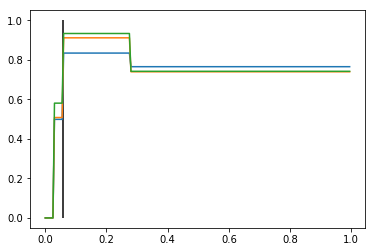

In [76]:
plot(resolutions, MI_)
plot(resolutions, RS)
plot(resolutions, MI_cl) #verde
vlines(0.057, 0, 1)

In [77]:
louvain_vs_SBM=pd.DataFrame(index=resolutions, columns=SBM_gruppi)

In [78]:
MI_louvain_NSBM0= [sklearn.metrics.adjusted_mutual_info_score( NSBM[0], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM1= [sklearn.metrics.adjusted_mutual_info_score( NSBM[1], louvain_clusters.loc[:,x]) for x in resolutions]
MI_louvain_NSBM2= [sklearn.metrics.adjusted_mutual_info_score( NSBM[2], louvain_clusters.loc[:,x]) for x in resolutions]

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will ch

In [79]:
louvain_vs_SBM.loc[:,0]=MI_louvain_NSBM0
louvain_vs_SBM.loc[:,1]=MI_louvain_NSBM1
louvain_vs_SBM.loc[:,2]=MI_louvain_NSBM2

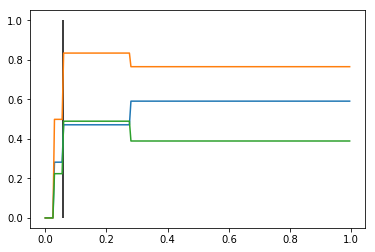

In [80]:
plot(louvain_vs_SBM)
vlines(0.057, 0, 1)

In [81]:
louvain_vs_SBM.to_csv('adata_dropseq/dropseq_mi_louvain_nsbm.csv')

# Sampling for the posterior distribution

In [82]:
bs = n_state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

In [83]:
state = n_state.copy(bs=bs, sampling=True)

In [84]:
dS, nattempts, nmoves = state.mcmc_sweep(niter=1000)

print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

Change in description length: 0.6110356220493429
Number of accepted vertex moves: 100879


In [85]:
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))

(3115.4072130547984, 9262926, 4902686)

In [103]:
pickle.dump(state, open("adata_dropseq/dropseq_equilibrate_state.pkl", "wb"), 2)

In [86]:
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1

In [87]:
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_num_groups)

(3111.1345526932387, 20280858, 10270154)

In [88]:
import pickle #per salvare la lista h come una variabile

In [104]:
pickle.dump(h, open('adata_dropseq/dropseq_block_probability.pkl', 'wb'),2)

### selezionare il modello migliore in base all'entropia del grafo e alla sua description length

In [90]:
nL = 10

for deg_corr in [True, False]:
    state = gt.minimize_nested_blockmodel_dl(g, deg_corr=deg_corr) 

In [91]:
bs = state.get_bs()                     
bs += [np.zeros(1)] * (nL - len(bs))

In [92]:
state = state.copy(bs=bs, sampling=True)

In [93]:
dls = []                               # description length history
vm = [None] * len(state.get_levels())  # vertex marginals
em = None                              # edge marginals

In [94]:
def collect_marginals(s):
    global vm, em
    levels = s.get_levels()
    vm = [sl.collect_vertex_marginals(vm[l]) for l, sl in enumerate(levels)]
    em = levels[0].collect_edge_marginals(em)
    dls.append(s.entropy())

In [95]:
gt.mcmc_equilibrate(state, force_niter=20000, mcmc_args=dict(niter=10), callback=collect_marginals)

(3105.876932656714, 40723938, 19267710)

In [96]:
S_mf = [gt.mf_entropy(sl.g, vm[l]) for l, sl in enumerate(state.get_levels())]
S_bethe = gt.bethe_entropy(g, em)[0]
L = -mean(dls)

print("Model evidence for deg_corr = %s:" % deg_corr, L + sum(S_mf), "(mean field),", L + S_bethe + sum(S_mf[1:]), "(Bethe)")


Model evidence for deg_corr = False: -2908.577355109384 (mean field), -3137.225637583863 (Bethe)
